# **Potential Fraud Detection Pipeline**
Dataset source : (https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection?resource=download)

In [0]:
# Data manipulation
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Visualization and plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


**_Data Ingestion(Extraction)_**

In [0]:
# Read csv file 

df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/lonewolf13011999@gmail.com/bank_transactions_data_2.csv")

# Shows first five rows of dataset
df.show(5)

+-------------+---------+-----------------+-------------------+---------------+---------+--------+--------------+----------+-------+-----------+------------------+-------------------+-------------+--------------+-----------------------+
|TransactionID|AccountID|TransactionAmount|    TransactionDate|TransactionType| Location|DeviceID|    IP Address|MerchantID|Channel|CustomerAge|CustomerOccupation|TransactionDuration|LoginAttempts|AccountBalance|PreviousTransactionDate|
+-------------+---------+-----------------+-------------------+---------------+---------+--------+--------------+----------+-------+-----------+------------------+-------------------+-------------+--------------+-----------------------+
|     TX000001|  AC00128|            14.09|2023-04-11 16:29:14|          Debit|San Diego| D000380|162.198.218.92|      M015|    ATM|         70|            Doctor|                 81|            1|       5112.21|    2024-11-04 08:08:08|
|     TX000002|  AC00455|           376.24|2023-06-2

In [0]:

# Typecasting the columns(from stringd to Integer and DateFormat)
df_casted = df \
    .withColumn("TransactionAmount", col("TransactionAmount").cast(DoubleType())) \
    .withColumn("AccountBalance", col("AccountBalance").cast(DoubleType())) \
    .withColumn("TransactionDuration", col("TransactionDuration").cast(DoubleType())) \
    .withColumn("CustomerAge", col("CustomerAge").cast(IntegerType())) \
    .withColumn("LoginAttempts", col("LoginAttempts").cast(IntegerType())) \
    .withColumn("TransactionDate", col("TransactionDate").cast(TimestampType())) \
    .withColumn("PreviousTransactionDate", col("PreviousTransactionDate").cast(TimestampType()))

# Verify the Schema after typecasting.
df_casted.printSchema()


root
 |-- TransactionID: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- TransactionAmount: double (nullable = true)
 |-- TransactionDate: timestamp (nullable = true)
 |-- TransactionType: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- DeviceID: string (nullable = true)
 |-- IP Address: string (nullable = true)
 |-- MerchantID: string (nullable = true)
 |-- Channel: string (nullable = true)
 |-- CustomerAge: integer (nullable = true)
 |-- CustomerOccupation: string (nullable = true)
 |-- TransactionDuration: double (nullable = true)
 |-- LoginAttempts: integer (nullable = true)
 |-- AccountBalance: double (nullable = true)
 |-- PreviousTransactionDate: timestamp (nullable = true)



**_Data Cleaning_**

In [0]:
# Fill the null values

df_cleaned = df_casted.fillna({
    "TransactionAmount": 0.0,
    "AccountBalance": 0.0,
    "LoginAttempts": 0,
    "TransactionDuration": 0.0,
    "CustomerOccupation": "Unknown",
    "Location": "Unknown",
    "DeviceID": "Unknown",
    "Channel": "Unknown",
    "MerchantID": "Unknown",
    "IP Address": "Unknown"
})

**_Data Transformation_**

In [0]:
# Calculating the number of days since last transaction

df_cleaned = df_cleaned.withColumn(
    "days_since_last_txn",
    when(col("PreviousTransactionDate").isNull(), -1).otherwise(
        datediff(to_date("TransactionDate", "yyyy-MM-dd"), to_date("PreviousTransactionDate", "yyyy-MM-dd"))
    )
)

# Calculating the transaction amount to account balance ratio
df_cleaned = df_cleaned.withColumn(
    'txn_to_balance_ratio',
    when(col("AccountBalance") == 0, 0)
    .otherwise(round(col("TransactionAmount") / col("AccountBalance"), 2))
)

# Checking for Transactions amount higher than 1000 dollars and marking them as 1
df_cleaned = df_cleaned.withColumn("is_high_value_txn",when(col("TransactionAmount")>1000,1).otherwise(0))

# Fetching the Transaction hour from Transaction Date
df_cleaned = df_cleaned.withColumn('txn_hour',hour(col('TransactionDate')))

# Fetching the Transaction day from Transaction Date
df_cleaned = df_cleaned.withColumn("txn_dayofweek", dayofweek(col("TransactionDate")))


# Show top 5 rows after Transformation
df_cleaned.show(5)

+-------------+---------+-----------------+-------------------+---------------+---------+--------+--------------+----------+-------+-----------+------------------+-------------------+-------------+--------------+-----------------------+-------------------+--------------------+-----------------+--------+-------------+
|TransactionID|AccountID|TransactionAmount|    TransactionDate|TransactionType| Location|DeviceID|    IP Address|MerchantID|Channel|CustomerAge|CustomerOccupation|TransactionDuration|LoginAttempts|AccountBalance|PreviousTransactionDate|days_since_last_txn|txn_to_balance_ratio|is_high_value_txn|txn_hour|txn_dayofweek|
+-------------+---------+-----------------+-------------------+---------------+---------+--------+--------------+----------+-------+-----------+------------------+-------------------+-------------+--------------+-----------------------+-------------------+--------------------+-----------------+--------+-------------+
|     TX000001|  AC00128|            14.09|

## Exploratory Data Analysis
## 

In [0]:
# Grouping the data based on most common transaction types
df_cleaned.groupBy(col("TransactionType")).count().orderBy("count",ascending = False).show()

+---------------+-----+
|TransactionType|count|
+---------------+-----+
|          Debit| 1944|
|         Credit|  568|
+---------------+-----+



In [0]:
# Calculating the average transaction amount per type
df.groupBy(col("TransactionType")).agg(round(avg(col('TransactionAmount')),2).alias("avg_transaction_amount")).\
                                       orderBy("avg_transaction_amount",ascending = False).show()

+---------------+----------------------+
|TransactionType|avg_transaction_amount|
+---------------+----------------------+
|         Credit|                 306.5|
|          Debit|                294.99|
+---------------+----------------------+



In [0]:
# Calculating the High-value transactions by channel

df_cleaned.filter(col("is_high_value_txn") == 1)\
    .groupBy("Channel").count().orderBy("count", ascending=False).show()


+-------+-----+
|Channel|count|
+-------+-----+
|    ATM|   33|
| Branch|   29|
| Online|   28|
+-------+-----+



In [0]:
# Calculating Transactions by hour of day (to spot peak/fraud-prone times)

df_cleaned.groupBy("txn_hour").count().orderBy("txn_hour").show()


+--------+-----+
|txn_hour|count|
+--------+-----+
|      16| 1316|
|      17|  819|
|      18|  377|
+--------+-----+



In [0]:
# Calculating the Top 10 locations with most transactions

df_cleaned.groupBy("Location").count().orderBy("count", ascending=False).show(10)


+-------------+-----+
|     Location|count|
+-------------+-----+
|   Fort Worth|   70|
|  Los Angeles|   69|
|Oklahoma City|   68|
|    Charlotte|   68|
| Philadelphia|   67|
|       Tucson|   67|
|        Omaha|   65|
|        Miami|   64|
|      Detroit|   63|
|      Memphis|   63|
+-------------+-----+
only showing top 10 rows



# Detect Anomalous Patterns (Heuristic Rules)

In [0]:
#Flag potentially suspicious transactions using simple rules:


# High number of login attempts (e.g., > 3)
df_cleaned = df_cleaned.withColumn(       
    "suspicious_login",
    when(col("LoginAttempts") > 3, 1).otherwise(0)
# Large transactions relative to balance (e.g., txn_to_balance_ratio > 0.7)
).withColumn(
    "suspicious_ratio",
    when(col("txn_to_balance_ratio") > 0.7, 1).otherwise(0)
    # Very short or long transaction durations
).withColumn(
    "suspicious_duration",
    when((col("TransactionDuration") < 2) | (col("TransactionDuration") > 180), 1).otherwise(0)
)


In [0]:
# calculate the count and mean of the derived columns
df_cleaned.select("suspicious_login", "suspicious_ratio", "suspicious_duration").summary("count", "mean").show()


+-------+--------------------+-------------------+-------------------+
|summary|    suspicious_login|   suspicious_ratio|suspicious_duration|
+-------+--------------------+-------------------+-------------------+
|  count|                2512|               2512|               2512|
|   mean|0.025477707006369428|0.06329617834394904|0.15605095541401273|
+-------+--------------------+-------------------+-------------------+



In [0]:
# Create an Overall Suspicion Score
df_cleaned = df_cleaned.withColumn(
    "suspicion_score",
    col("suspicious_login") + col("suspicious_ratio") + col("suspicious_duration")
)

In [0]:
# Label the potential fradulent transactions based on suspucion score
df_cleaned = df_cleaned.withColumn(
    "is_fraud_like",
    when(col("suspicion_score") >= 2, 1).otherwise(0)
)


**_Fraud-Like Patterns Exploration_**

In [0]:

# Fetch accounts having the most fraud-like transactions
df_cleaned.filter(col("is_fraud_like") == 1) \
    .groupBy("AccountID") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(10, truncate=False)


+---------+-----+
|AccountID|count|
+---------+-----+
|AC00454  |2    |
|AC00253  |2    |
|AC00177  |2    |
|AC00169  |1    |
|AC00039  |1    |
|AC00081  |1    |
|AC00470  |1    |
|AC00378  |1    |
|AC00107  |1    |
|AC00412  |1    |
+---------+-----+
only showing top 10 rows



In [0]:
# Fetching the specific hours that are fraud-prone

df_cleaned.filter(col("is_fraud_like") == 1) \
    .groupBy("txn_hour") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()


+--------+-----+
|txn_hour|count|
+--------+-----+
|      16|   22|
|      17|   14|
|      18|    8|
+--------+-----+



In [0]:
# Fetching fraud-like transactions that more common in specific channels

df_cleaned.filter(col("is_fraud_like") == 1) \
    .groupBy("Channel") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()


+-------+-----+
|Channel|count|
+-------+-----+
|    ATM|   15|
| Online|   15|
| Branch|   14|
+-------+-----+



In [0]:
# Do merchant IDs show signs of repeated suspicious activity

df_cleaned.filter(col("is_fraud_like") == 1) \
    .groupBy("MerchantID") \
    .count() \
    .orderBy(col("count").desc()) \
    .show(10, truncate=False)


+----------+-----+
|MerchantID|count|
+----------+-----+
|M052      |2    |
|M003      |2    |
|M015      |2    |
|M045      |2    |
|M033      |2    |
|M011      |1    |
|M032      |1    |
|M040      |1    |
|M054      |1    |
|M085      |1    |
+----------+-----+
only showing top 10 rows



# Prepare Data for Machine Learning

In [0]:
# Feature Vector Assembly
# Select your features
feature_cols = [
    "TransactionAmount", "AccountBalance", "days_since_last_txn",
    "txn_to_balance_ratio", "txn_hour", "txn_dayofweek",
    "suspicious_login", "suspicious_duration", "suspicious_ratio"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model_ready = assembler.transform(df_cleaned).select("features", "is_fraud_like")

In [0]:
# Logistic Regression for binary classification
# Split the data between training and testing data
train_data, test_data = df_model_ready.randomSplit([0.8, 0.2], seed=42)

# Train a Logistic Regression model
lr = LogisticRegression(labelCol="is_fraud_like", featuresCol="features")
lr_model = lr.fit(train_data)

# Predictions
predictions = lr_model.transform(test_data)
predictions.select("is_fraud_like", "prediction", "probability").show(10, truncate=False)


+-------------+----------+------------------------------------------+
|is_fraud_like|prediction|probability                               |
+-------------+----------+------------------------------------------+
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[0.9999999895095987,1.0490401325391474E-8]|
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[1.0,0.0]                                 |
|0            |0.0       |[0.9999999887080312,1.1291968804449937E-8]|
|0            |0.0       |[1.0,0.0]                                 |
+-------------+----------+------------------------------------------+
only showing top 10 

In [0]:
# Evaluate AUC (Area Under ROC Curve)

binary_evaluator = BinaryClassificationEvaluator(
    labelCol="is_fraud_like", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
)
auc = binary_evaluator.evaluate(predictions)
print(f"AUC (Area Under ROC): {auc}")


AUC (Area Under ROC): 1.0


In [0]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud_like", predictionCol="prediction")

accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [0]:
df_cleaned.groupBy("is_fraud_like").count().show()


+-------------+-----+
|is_fraud_like|count|
+-------------+-----+
|            1|   44|
|            0| 2468|
+-------------+-----+



# Visualizations in PySpark + Pandas

In [0]:
# Convert a small sample to Pandas
pandas_df = df_cleaned.sample(fraction=0.1, seed=42).toPandas()


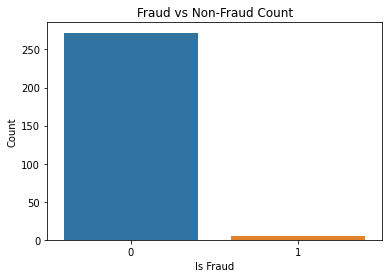

In [0]:
# Fraud distribution
sns.countplot(x='is_fraud_like', data=pandas_df)
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()


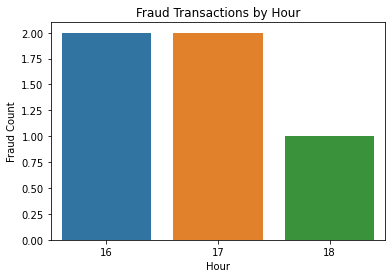

In [0]:
# Fraud by transaction hour
fraud_hourly = pandas_df[pandas_df["is_fraud_like"] == 1]
sns.countplot(x='txn_hour', data=fraud_hourly, order=sorted(fraud_hourly["txn_hour"].unique()))
plt.title("Fraud Transactions by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Count")
plt.show()


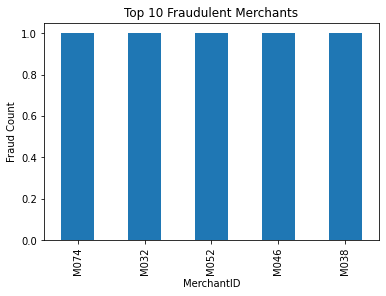

In [0]:
# Top 10 fraud merchants

top_merchants = pandas_df[pandas_df["is_fraud_like"] == 1]["MerchantID"].value_counts().head(10)
top_merchants.plot(kind='bar')
plt.title("Top 10 Fraudulent Merchants")
plt.xlabel("MerchantID")
plt.ylabel("Fraud Count")
plt.show()


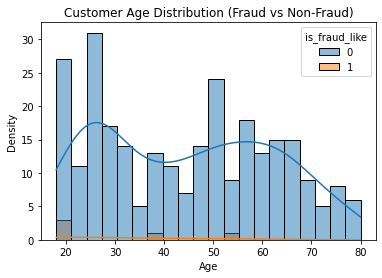

In [0]:
# Age distribution by fraud
sns.histplot(data=pandas_df, x="CustomerAge", hue="is_fraud_like", kde=True, bins=20)
plt.title("Customer Age Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()


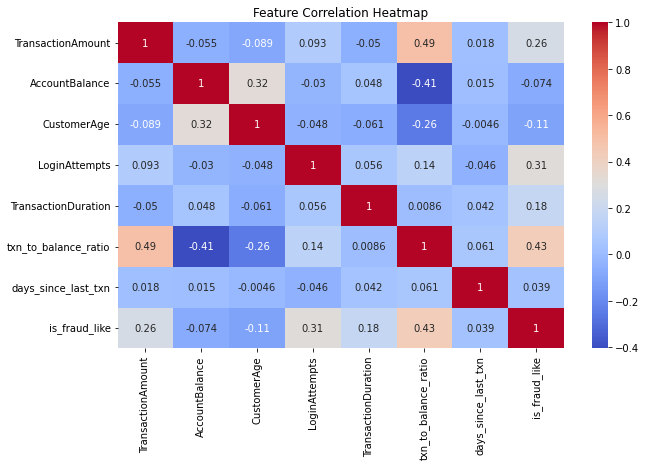

In [0]:
# Correlation heatmap
corr = pandas_df[["TransactionAmount", "AccountBalance", "CustomerAge", 
                  "LoginAttempts", "TransactionDuration", "txn_to_balance_ratio", 
                  "days_since_last_txn", "is_fraud_like"]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()
